In [1]:
import pandas as pd 
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

import mahalanobis as maha
import visual   # for interactive plots

In [2]:
df = pd.read_parquet('data/covid_screen.parquet')
df.rename(columns={"cbkid": "batch_id"}, inplace=True)

# Reorder the columns: first 7 are metadata, others are morphology
columns = df.columns.tolist()
new_columns = columns[:2] + columns[-5:] + columns[2:-5] 
df = df[new_columns]

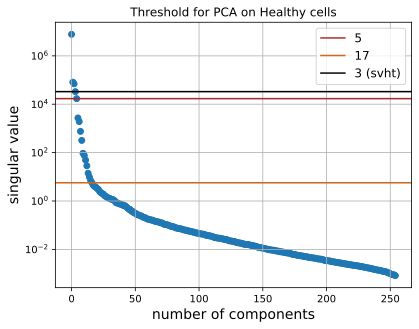

In [3]:
df_healthy = df[df['batch_id'] == 'Uninfected']
x_healthy = df_healthy.iloc[:, 7:].to_numpy()

sigma, rank = maha.get_singular_values(x_healthy)
plt.scatter(range(rank), sigma[:rank])

n_components = 5
plt.axhline(sigma[n_components - 1], c='brown', label=n_components)

n_components = np.count_nonzero(sigma > 5)
plt.axhline(sigma[n_components - 1], c='chocolate', label=n_components)

# optimal threshold for PCA of Healthy cells
tau = maha.svht(x_healthy)
plt.axhline(sigma[int(tau)], c='k', label=f'{int(tau)} (svht)')

plt.grid()
plt.yscale('log')
plt.legend(fontsize=12)
plt.xlabel('number of components', fontsize=14)
plt.ylabel('singular value', fontsize=14)
plt.title("Threshold for PCA on Healthy cells")
plt.show()

In [4]:
x_all = df.iloc[:, 7:].copy()
clip = 50 # if we want to clip eventual extreme values; otherwise float('inf')
x_all.clip(lower=-clip, upper=clip, inplace=True)

In [5]:
# Predictions based on whitening transform
n_components = 5

# Distance to Healthy (Mahalanobis)
df_healthy = df[df['batch_id'] == 'Uninfected']
x_healthy = df_healthy.iloc[:, 7:].to_numpy()
dist_pred = maha.get_distance(x_healthy, x_all, n_components=n_components)
dist_pred = pd.DataFrame(dist_pred, columns=['distance'])

# Probability of Healthy
proba_pred = maha.get_proba(x_healthy, x_all, n_components=n_components)
proba_pred = pd.DataFrame(proba_pred, columns=['proba'])

In [6]:
predictions = pd.concat([df.iloc[:, :7], dist_pred, proba_pred], axis=1)

In [7]:
def quantile(n):
    def quantile_(x):
        return x.quantile(n)
    quantile_.__name__ = f'q_{n*100:.0f}'
    return quantile_

selected_columns = predictions[[
    'batch_id',
    'Count_nuclei',
    'distance',
    # 'proba',
    'name',
]].copy()

# Add concetration column (dummy due to only single dose measurements in screening)
selected_columns['conc'] = 10.

# Aggregate replicates
average_predictions = selected_columns.groupby(by=['batch_id', 'name', 'conc'], as_index=False).agg({
        'Count_nuclei': 'median',
        'distance': [quantile(.25), quantile(.75), 'median'],
        # 'proba': 'median',
})

# Rename columns
custom_columns = [''.join(col) for col in average_predictions.columns.to_flat_index() if not col[1]]
custom_columns += ['_'.join(col) for col in average_predictions.columns.to_flat_index() if col[1]]
average_predictions.columns = custom_columns
average_predictions.rename(columns={'Count_nuclei_median': 'count_nuclei'}, inplace=True)
average_predictions.rename(columns={'distance_median': 'distance'}, inplace=True)

# Sort by distance to non-infected
average_predictions.sort_values(by=['distance'], ascending=True, inplace=True)

# Quantiles are written as plus/minus to the median
average_predictions['distance_q_75'] = average_predictions['distance_q_75'] - average_predictions['distance']
average_predictions['distance_q_25'] =  average_predictions['distance'] - average_predictions['distance_q_25']

average_predictions.reset_index(inplace=True, drop=True)
average_predictions.to_csv("output/Covid_screen_ranked.csv", sep=';')
average_predictions.head(20)

batch_id                      name  conc  count_nuclei  distance_q_25  \
0   CBK290949     Cathepsin Inhibitor 1  10.0    267.285714            0.0   
1   CBK290899                Triptolide  10.0    173.500000            0.0   
2   CBK040966  3'-fluorobenzylspiperone  10.0    263.000000            0.0   
3   CBK309514                  SKLB1002  10.0    218.000000            0.0   
4   CBK303979        LY2584702 tosylate  10.0    179.000000            0.0   
5   CBK290789             DOXIFLURIDINE  10.0    180.400000            0.0   
6   CBK309558      SRT2104 (GSK2245840)  10.0    225.142857            0.0   
7   CBK290427   Loxistatin Acid (E-64C)  10.0    202.750000            0.0   
8   CBK293866            TIC10 analogue  10.0    205.500000            0.0   
9   CBK040900       diphenyleneiodonium  10.0    194.000000            0.0   
10  CBK303902                   AZD7545  10.0    205.000000            0.0   
11  CBK303981                 LY3009120  10.0    224.666667            0.0   
12  CBK041960       KANAMYCIN A SULFATE  10.0    214.571429            0.0   
13  CBK309526                    IWP L6  10.0    224.222222            0.0   
14  CBK290896       Indacaterol Maleate  10.0    208.800000            0.0   
15  CBK309550                     ML167  10.0    207.142857            0.0   
16  CBK309485                      BAM7  10.0    198.571429            0.0   
17  CBK011621                paclitaxel  10.0    268.600000            0.0   
18  CBK290571                IRBESARTAN  10.0    200.777778            0.0   
19  CBK290276                   SLV-320  10.0    197.000000            0.0   

    distance_q_75   distance  
0             0.0  34.097113  
1             0.0  34.098751  
2             0.0  34.098997  
3             0.0  34.099207  
4             0.0  34.099423  
5             0.0  34.099653  
6             0.0  34.099777  
7             0.0  34.100065  
8             0.0  34.100164  
9             0.0  34.100225  
10            0.0  34.100487  
11            0.0  34.100594  
12            0.0  34.100677  
13            0.0  34.100746  
14            0.0  34.100778  
15            0.0  34.100786  
16            0.0  34.100814  
17            0.0  34.101050  
18            0.0  34.101074  
19            0.0  34.101075

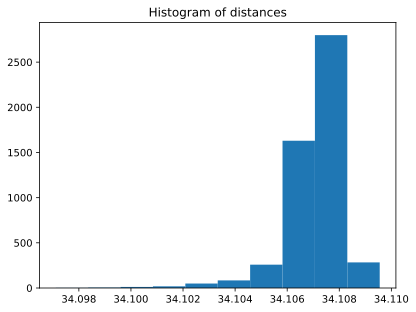

In [8]:
plt.hist(average_predictions['distance'])
plt.title("Histogram of distances")
plt.show()

In [13]:
compounds = average_predictions.copy()
dmso = compounds[compounds['batch_id'] == 'DMSO']

visual.plot_compounds_interactive(compounds, dmso, n_components)

### Primary hits

In [12]:
# Read the type of drug: primary hit, secondary hit, or analog

subset = pd.read_csv("data/metadata_annotations.csv", usecols=["CBCSbatch_id", "arm"])
subset.rename(columns={"CBCSbatch_id": "batch_id", "arm": "type"}, inplace=True)

with open("data/id_to_name.txt", 'r') as file:
    table = file.readlines()
    id_to_name = {}
    for i, line in enumerate(table):
        id_, name = line.rstrip().split('\t')
        id_to_name[id_] = name

subset['name'] = subset['batch_id'].map(id_to_name)

In [14]:
# Extract primary hit
primary_hit_name = subset[subset['type'] == 'primary_hit']['name'].to_list()
primary_hits = compounds[compounds['name'].isin(primary_hit_name)].copy()

visual.plot_compounds_interactive(primary_hits, dmso, n_components)

### Secondary hits

In [15]:
# Extract secondary hit
secondary_hit_name = subset[subset['type'] == 'secondary_cp_hit']['name'].to_list()
secondary_hits = compounds[compounds['name'].isin(secondary_hit_name)].copy()

visual.plot_compounds_interactive(secondary_hits, dmso, n_components)

Output `secondary_hits` and `DMSO` as a reference

In [16]:
secondary_hits_to_save = pd.concat([secondary_hits, dmso], ignore_index=True)
secondary_hits_to_save.rename(columns={'batch_id': 'cbkid'}, inplace=True)
secondary_hits_to_save.to_csv("output/secondary_hits_screen.csv", sep=';', index=False)